<h1 align="center"> Battle of Neighbourhoods - London vs Toronto</h1>

By Samuel Pediredla

2nd may, 2021

## 1. Introduction
London and Toronto area unit quite the popular holidaymaker and vacation destinations for folks all round the world. they're various and school of thought and supply a good style of experiences that's wide wanted. we have a tendency to attempt to cluster the neighbourhoods of London and Toronto severally and draw insights to what they give the impression of being like currently.

## 2. Business Problem
The aim is to help tourists choose their destinations depending on the experiences that the neighbourhoods have to offer and what they would want to have. This also helps people make decisions if they are thinking about migrating to London or Toronto or even if they want to relocate neighbourhoods within the city. Our findings will help stakeholders make informed decisions and address any concerns they have including the different kinds of cuisines, provision stores and what the city has to offer.

## 3. Data Description

We require the geo location data of both the cities. we need the postal codes to find the nearby neighbourhoods, boroughs, venues and their most popular venue categories.

## 3.1 London
To derive our solution, We scrape our data from https://en.wikipedia.org/wiki/List_of_areas_of_London

This wikipedia page has information about all the neighbourhoods, we limit it London.

1. *borough* : Name of Neighbourhood
2. *town* : Name of borough
3. *post_code* : Postal codes for London.

This wikipedia page lacks information about the geographical locations. To solve this problem we use ArcGIS API

## 3.2 ArcGIS API
we use ArcGIS to get the geo locations of the neighbourhoods of London. The following columns are added to our initial dataset which prepares our data. 

4. *latitude* : Latitude for Neighbourhood
5. *longitude* : Longitude for Neighbourhood

## 3.3 Toronto

To derive our solution, We scrape the data from https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&direction=prev&oldid=926287641


The JSON file has data about all the neighbourhoods in Canada, we limit to toronto.

1. *post_code* : Postal codes for Toronto.
2. *borough* : Name of the boroughs
3. *Neighbourhood* : Name of Neighbourhood

We use data from https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv to get the latitudes and logitudes for the postal codes. 

4. *latitude* : Latitude for Neighbourhood
5. *longitude* : Longitude for Neighbourhood

## 3.4 Foursquare API Data

We will like knowledge regarding totally different venues in numerous neighbourhoods of that specific borough. so as to realize that info we'll use "Foursquare" locational info. Foursquare may be a location knowledge supplier with info regarding all manner of venues and events at intervals a part of interest. Such info includes venue names, locations, menus and even photos. As such, the foursquare location platform are going to be used because the sole knowledge supply since all the expressed needed info are often obtained through the API.

After finding the list of neighbourhoods, we then connect to the Foursquare API to gather information about venues inside each and every neighbourhood. For each neighbourhood, we have chosen the radius to be 500 meters.

Based on all the knowledge collected for each London and Toronto, we've got spare information to create our model. we have a tendency to cluster the neighbourhoods along supported similar venue classes. we have a tendency to then gift our observations and findings. victimization this information, our stakeholders will take the required call.

# 4. Methodology

We will be creating our model with the help of Python so we start off by importing all the required packages.

```python
import pandas as pd
import requests
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
from sklearn.cluster import KMeans
```

Package breakdown:


*   *Pandas* : To collect and manipulate data in JSON and HTMl and then data analysis
*   *requests* : Handle http requests
*   *matplotlib*  : Detailing the generated maps
*   *folium* : Generating maps of London and Toronto
* *sklearn* : To import Kmeans which is the machine learning model that we are using.





The approach taken here is to explore each of the cities individually, plot the map to show the neighbourhoods being considered and then build our model by clustering all of the similar neighbourhoods together and finally plot the new map with the clustered neighbourhoods. We draw insights and then compare and discuss our findings.



## 4.1 Data Collection

In the data collection stage, we begin with collecting the required data for the cities of London and Toronto. We need data that has the postal codes, neighbourhoods and boroughs specific to each of the cities. 

To collect data for London, we scrape the List of areas of London wikipedia page to take the 2nd table using the following code:

```python
url_london = "https://en.wikipedia.org/wiki/List_of_areas_of_London"
wiki_london_url = requests.get(url_london)
wiki_london_data = pd.read_html(wiki_london_url.text)
wiki_london_data = wiki_london_data[1]
wiki_london_data
```

The data looks like this:

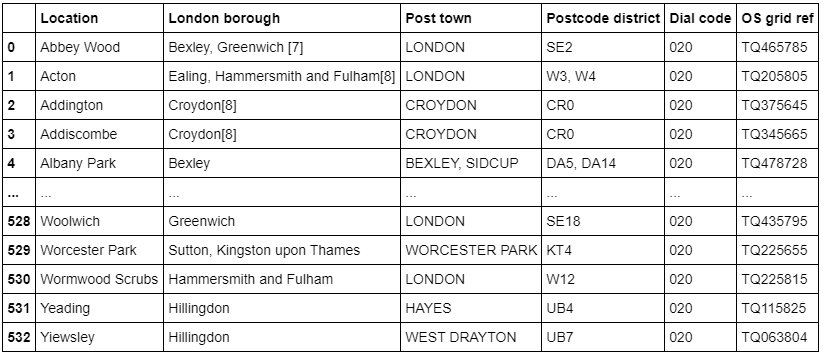

To collect data for Toronto, we scrape the List of areas of London wikipedia page to take the 2nd table using the following code:


```python
html_data = requests.get('https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&direction=prev&oldid=926287641')
wiki_raw = pd.read_html(html_data.content, header = 0)[0]
df1 = wiki_raw[wiki_raw.Borough != 'Not assigned']
df1 = df1.rename(columns={'Postcode': 'Postal Code','Neighbourhood':'Neighborhood'})
df1.reset_index(inplace = True)
del df1['index']
df1.head()
```

<img src="toronto.png" >

## 4.2 Data Preprocessing


For London, We replace the spaces with underscores in the title.The *borough* column has numbers within square brackets that we remove using:

```python
wiki_london_data.rename(columns=lambda x: x.strip().replace(" ", "_"), inplace=True)
wiki_london_data['borough'] = wiki_london_data['borough'].map(lambda x: x.rstrip(']').rstrip('0123456789').rstrip('['))
```

For Toronto, we merge each of the nested fields and create the dataframe that we need:

```python
df1_geo = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv')
df1 = df1.join(df1_geo.set_index('Postal Code'), on='Postal Code')
df1.head()
```



## 4.3 Feature Selection



For both of our datasets, we need only the borough, neighbourhood, postal codes and geolocations (latitude and longitude). So we end up selecting the columns that we need by:

```python
df = wiki_london_data.drop( [ wiki_london_data.columns[0], wiki_london_data.columns[4], wiki_london_data.columns[5] ], axis=1)

df_2 =Toronto_field_data[['postal_code','Borough','nNeighborhood']]
```



## 4.4 Feature Engineering

Looking over our London dataset, we can see that we don't have the geolocation data. We need to extrapolate the missing data for our neighbourhoods. We perform this by leveraging the `ArcGIS API`. With the Help of `ArcGIS API` we can get the latitude and longitude of our London neighbourhood data. 

```python
from arcgis.geocoding import geocode
from arcgis.gis import GIS
gis = GIS()
```

Defining London arcgis geocode function to return latitude and longitude

```python
def get_x_y_uk(address1):
   lat_coords = 0
   lng_coords = 0
   g = geocode(address='{}, London, England, GBR'.format(address1))[0]
   lng_coords = g['location']['x']
   lat_coords = g['location']['y']
   return str(lat_coords) +","+ str(lng_coords)
```

Passing postal codes of london to get the geographical co-ordinates

```python
coordinates_latlng_uk = geo_coordinates_uk.apply(lambda x: get_x_y_uk(x))
```

We proceed with Merging our source data with the geographical co-ordinates to make our dataset ready for the next stage

```python
london_merged = pd.concat([df1,lat_uk.astype(float), lng_uk.astype(float)], axis=1)
london_merged.columns= ['borough','town','post_code','latitude','longitude']
london_merged
```


For final Toronto dataframe, we merge our first dataframe with the csv with the coordinates


## 4.5 Visualizing the Neighbourhoods of London and Toronto

Now that our datasets are ready, using the `Folium` package, we can visualize the maps of London and Toronto with the neighbourhoods that we collected.

Neighbourhood map of London:

<img src="londonmap.png">

Neighbourhood map of Toronto:

<img src="torontomap.png">

Now that we have visualized the neighbourhoods, we need to find out what each neighbourhood is like and what are the common venue and venue categories within a 500m radius. 

This is where `Foursquare` comes into play. With the help of `Foursquare` we define a function which collects information pertaining to each neighbourhood including that of the name of the neighbourhood, geo-coordinates, venue and venue categories.

```python
LIMIT=100

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            LIMIT
            )
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Category']
    
    return(nearby_venues)
```




## 4.6 One Hot Encoding


Since we are trying to find out what are the different kinds of venue categories present in each neighbourhood and then calculate the top 10 common venues to base our similarity on, we use the One Hot Encoding to work with our categorical datatype of the venue categories. This helps to convert the categorical data into numeric data. 

We won't be using label encoding in this situation since label encoding might cause our machine learning model to have a bias or a sort of ranking which we are trying to avoid by using One Hot Encoding.

We perform one hot encoding and then calculate the mean of the grouped venue categories for each of the neighbourhoods.



```python
# One hot encoding
London_venue_cat = pd.get_dummies(venues_in_London[['Venue Category']], prefix="", prefix_sep="")

# Adding neighbourhood to the mix
London_venue_cat['Neighbourhood'] = venues_in_London['Neighbourhood'] 

# moving neighborhood column to the first column
fixed_columns = [London_venue_cat.columns[-1]] + list(London_venue_cat.columns[:-1])
London_venue_cat = London_venue_cat[fixed_columns]

# Grouping and calculating the mean
London_grouped = London_venue_cat.groupby('Neighbourhood').mean().reset_index()
```




## 4.7 Top Venues in the Neighbourhoods

In our next step, We need to rank and label the top venue categories in our neighborhood.

Let's define a function to get the top venue categories in the neighbourhood

```python
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
```

There are many categories, we will consider top 10 categories to avoid data skew. 

Defining a function to label them accurately

```python
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
```

Getting the top venue categories in the neighbourhoods of London

```python
# create a new dataframe for London
neighborhoods_venues_sorted_london = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_london['Neighbourhood'] = London_grouped['Neighbourhood']

for ind in np.arange(London_grouped.shape[0]):
    neighborhoods_venues_sorted_london.iloc[ind, 1:] = return_most_common_venues(London_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted_london.head()
```

<img src="topv.png">

## 4.8 Model Building - KMeans


Moving on to the most exicitng part - **Model Building!** We will be using KMeans Clustering Machine learning algorithm to cluster similar neighbourhoods together. We will be going with the number of clusters as 5.

```python
# set number of clusters
k_num_clusters = 5

London_grouped_clustering = London_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans_london = KMeans(n_clusters=k_num_clusters, random_state=0).fit(London_grouped_clustering)
```

Our model has labelled each of the neighbourhoods, we add the label into our dataset.

```python
neighborhoods_venues_sorted_london.insert(0, 'Cluster Labels', kmeans_london.labels_ +1)
```

We then join London_merged with our neighbourhood venues sorted to add latitude & longitude for each of the neighborhood to prepare it for visualization.

```python
london_data = london_merged

london_data = london_data.join(neighborhoods_venues_sorted_london.set_index('Neighbourhood'), on='borough')

london_data.head()
```


## 4.9 Visualizing the clustered Neighbourhoods

Our data is processed, missing data is collected and compiled. The Model is built. All that's remaining is to see the clustered neighbourhoods on the map. Again, we use `Folium` package to do so.

We drop all the NaN values to prevent data skew

```python
london_data_nonan = london_data.dropna(subset=['Cluster Labels'])
```

Map of clustered neighbourhoods of London:

<img src="kl.png">

Map of clustered neighbourhoods of Toronto:

<img src="kt.png">

### 4.9.1 Examining our Clusters

We could examine our clusters by expanding on our code using the `Cluster Labels` column:

Cluster 1

```python
london_data_nonan.loc[london_data_nonan['Cluster Labels'] == 1, london_data_nonan.columns[[1] + list(range(5, london_data_nonan.shape[1]))]]
```

Cluster 2

```python
london_data_nonan.loc[london_data_nonan['Cluster Labels'] == 2, london_data_nonan.columns[[1] + list(range(5, london_data_nonan.shape[1]))]]
```

Cluster 3

```python
london_data_nonan.loc[london_data_nonan['Cluster Labels'] == 3, london_data_nonan.columns[[1] + list(range(5, london_data_nonan.shape[1]))]]
```

Cluster 4

```python
london_data_nonan.loc[london_data_nonan['Cluster Labels'] == 4, london_data_nonan.columns[[1] + list(range(5, london_data_nonan.shape[1]))]]
```

Cluster 5

```python
london_data_nonan.loc[london_data_nonan['Cluster Labels'] == 5, london_data_nonan.columns[[1] + list(range(5, london_data_nonan.shape[1]))]]
```


# 5. Results and Discussion

The neighbourhoods of London area unit terribly mulitcultural. we've a 321 types of venues to attend. There area unit a great deal of various cusines as well as Indian, Italian, Turkish and Chinese. London appears to require a step any during this direction by having a great deal of Restaurants, bars, juice bars, occasional retailers, Fish and Chips look and Breakfast spots. it's a great deal of searching choices too thereupon of the epizoan markets, flower retailers, fish markets, Fishing stores, clothes shops. the most modes of transport appear to be Buses and trains. For leisure, the neighbourhoods area unit established to own many parks, golf courses, zoo, gyms and Historic sites.

Overall, town of London offers a doctrine, various and definitely AN entertaining  expertise.

Toronto is comparatively tiny in size geographically. it's a large form of cusines and eateries as well as French, Thai, Cambodian, Asian, Chinese etc. There area unit a great deal of country spots as well as several Restaurants and Bars. completely different means that of transport in provincial capital which has buses, bikes, boats or ferries. For leisure and sight seeing, there area unit a great deal of Plazas, Trails, Parks, Historic sites, covering retailers, Art galleries and Museums. Overall, provincial capital sensible|is sweet|is nice} place to migrate with good living conditions however london is best.

# 6. Conclusion

The purpose of this project was to explore the cities of London and Toronto and see however enticing it's to potential tourists and migrants. we have a tendency to explored each the cities supported their communicating codes and so compute the common venues gift in every of the neighbourhoods finally final with bunch similar neighbourhoods along.

We may see that every of the neighbourhoods in each the cities have a large style of experiences to supply that is exclusive in it's own method. The cultural diversity is kind of evident that conjointly offers the sensation of a way of inclusion.

Both Toronto and London appear to supply a vacation keep or a romantic gateaway with a great deal of places to explore, lovely landscapes and a large style of culture.Overall, it's upto the stakeholders to choose that expertise they'd like a lot of and which might a lot of to their feeling.